<a href="https://colab.research.google.com/github/evernever333/AI-YP24-Team-7/blob/main/Baseline/Baseline_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Улучшение Baseline: Добавление DL

## 1. Построение и анализ CNN-модели VegClassifier с использованием различных оптимизаторов (Исследование Алексея Дулгеру)

1.1 Импорты

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os

from PIL import Image

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import euclidean_distances

from types import MethodType

1.2 Загрузка и подготовка датасета

In [ ]:
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")
path = os.path.join(path, 'Vegetable Images')
base_dir = path
categories = ["train", "test", "validation"]

torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# называем датасеты и загружаем их
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
test_dataset = ImageFolder(os.path.join(base_dir, 'test'), transform=transform)
val_dataset = ImageFolder(os.path.join(base_dir, 'validation'), transform=transform)

1.3 Определение модели VegClassifier (CNN-архитектура)

In [ ]:
class VegClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VegClassifier, self).__init__()
        """ Cтроим блоки для cnn """
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

1.4 Функция обучения и оценки модели (train_and_evaluate)

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, criterion,
                       epochs=10, optimizer_name="Optimizer"):
    """Обучаем модельку и оцениваем на validation сете после каждой эпохи"""

    best_val_acc = 0
    train_losses = []

    for epoch in range(epochs):
        # Обучаемся
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset) # считаем loss
        train_losses.append(epoch_loss)

        # Валидация
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Считаем метрики для валидации
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Выводим инфу по каждой эпохе
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch + 1}/{epochs} | '
              f'Loss: {epoch_loss:.4f} | '
              f'Val Acc: {val_acc:.4f} | '
              f'Val F1: {val_f1:.4f} | '
              f'Time: {epoch_time:.2f}s')

        # Смотрим какая моделька лучше и сохраняем
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'vegetable_cnn_{optimizer_name}.pt')

    model.load_state_dict(torch.load(f'vegetable_cnn_{optimizer_name}.pt'))

    # Оцениваем performance на тестовых данных
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    test_precision = precision_score(all_labels, all_preds, average='weighted')
    test_recall = recall_score(all_labels, all_preds, average='weighted')

    return {
        'accuracy': test_acc,
        'f1': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'train_losses': train_losses
    }

1.5 Определение устройства (CPU/GPU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


1.6 Обучение моделей с разными оптимизаторами и сравнение результатов

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
num_classes = len(train_dataset.classes)

# функция потерь
criterion = nn.CrossEntropyLoss()

# инициируем модельки
sgd_model = VegClassifier(num_classes).to(device)
adam_model = VegClassifier(num_classes).to(device)
rmsprop_model = VegClassifier(num_classes).to(device)

# добавляем оптимайзеры
sgd_optimizer = torch.optim.SGD(sgd_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
adam_optimizer = torch.optim.Adam(adam_model.parameters(), lr=0.001, weight_decay=1e-4)
rmsprop_optimizer = torch.optim.RMSprop(rmsprop_model.parameters(), lr=0.001, alpha=0.99, weight_decay=1e-4)

print("\n=== Training with SGD+momentum ===")
sgd_results = train_and_evaluate(
    sgd_model, train_loader, val_loader, test_loader,
    sgd_optimizer, criterion, epochs=10, optimizer_name="SGD"
)

print("\n=== Training with Adam ===")
adam_results = train_and_evaluate(
    adam_model, train_loader, val_loader, test_loader,
    adam_optimizer, criterion, epochs=10, optimizer_name="Adam"
)

print("\n=== Training with RMSprop ===")
rmsprop_results = train_and_evaluate(
    rmsprop_model, train_loader, val_loader, test_loader,
    rmsprop_optimizer, criterion, epochs=10, optimizer_name="RMSprop"
)

print("\n=== Optimizer Performance Comparison ===")
print(f"{'Optimizer':<10} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 50)
print(
    f"SGD        {sgd_results['accuracy']:.4f}     {sgd_results['f1']:.4f}     {sgd_results['precision']:.4f}     {sgd_results['recall']:.4f}")
print(
    f"Adam       {adam_results['accuracy']:.4f}     {adam_results['f1']:.4f}     {adam_results['precision']:.4f}     {adam_results['recall']:.4f}")
print(
    f"RMSprop    {rmsprop_results['accuracy']:.4f}     {rmsprop_results['f1']:.4f}     {rmsprop_results['precision']:.4f}     {rmsprop_results['recall']:.4f}")


=== Training with SGD+momentum ===
Epoch 1/10 | Loss: 0.8600 | Val Acc: 0.8640 | Val F1: 0.8607 | Time: 33.26s
Epoch 2/10 | Loss: 0.3221 | Val Acc: 0.9033 | Val F1: 0.9044 | Time: 34.88s
Epoch 3/10 | Loss: 0.1785 | Val Acc: 0.9607 | Val F1: 0.9607 | Time: 34.01s
Epoch 4/10 | Loss: 0.1325 | Val Acc: 0.9623 | Val F1: 0.9630 | Time: 34.45s
Epoch 5/10 | Loss: 0.1020 | Val Acc: 0.9803 | Val F1: 0.9803 | Time: 33.35s
Epoch 6/10 | Loss: 0.0687 | Val Acc: 0.9797 | Val F1: 0.9796 | Time: 34.24s
Epoch 7/10 | Loss: 0.0635 | Val Acc: 0.9860 | Val F1: 0.9860 | Time: 33.86s
Epoch 8/10 | Loss: 0.0526 | Val Acc: 0.9773 | Val F1: 0.9770 | Time: 33.79s
Epoch 9/10 | Loss: 0.0448 | Val Acc: 0.9833 | Val F1: 0.9833 | Time: 33.09s
Epoch 10/10 | Loss: 0.0322 | Val Acc: 0.9877 | Val F1: 0.9876 | Time: 33.32s

=== Training with Adam ===
Epoch 1/10 | Loss: 0.7049 | Val Acc: 0.8207 | Val F1: 0.8182 | Time: 33.45s
Epoch 2/10 | Loss: 0.2614 | Val Acc: 0.9053 | Val F1: 0.9070 | Time: 33.68s
Epoch 3/10 | Loss: 0.16

## Вывод по сравнению оптимизаторов

В ходе эксперимента была проведена серия запусков обучения модели `VegClassifier` с использованием трёх различных оптимизаторов: **SGD с momentum**, **Adam** и **RMSprop**. Каждая модель обучалась в течение 10 эпох с одинаковыми параметрами и архитектурой.

- **SGD с momentum** показал наиболее стабильный и уверенный рост метрик. Уже к 5-й эпохе точность модели на валидации превысила 98%, а к 10-й достигла **Val Acc = 0.9877**, продемонстрировав наилучшие результаты по всем ключевым метрикам. На тестовой выборке точность составила **0.9863**, что делает данный оптимизатор наиболее эффективным в данной задаче.

- **Adam** обеспечил быстрое схождение на первых эпохах и достиг **Val Acc = 0.9830** на 7-й эпохе. Однако ближе к концу обучения наблюдаются признаки переобучения или переадаптации, и итоговая точность на тесте составила **0.9800**.

- **RMSprop** показал неплохие результаты, особенно начиная с 4-й эпохи, но имел менее стабильную динамику, чем Adam и SGD. Финальная точность на тестовой выборке составила **0.9737**, что делает его наименее предпочтительным из трёх.

Таким образом, на текущем этапе можно заключить, что **SGD с momentum** обеспечивает наилучшее качество классификации при заданной архитектуре и условиях обучения. Adam и RMSprop также показывают достойные результаты, однако немного уступают в итоговой точности и стабильности обучения.

## 2. Анализ аугментационных стратегий и их влияния на качество классификации в модели VegClassifier (Исследование Татьяны Жаровой)

2.1 Функция визуализации аугментированных изображений

In [ ]:
def show_augmented_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img, _ = dataset[np.random.randint(len(dataset))]
        axes[i].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
        axes[i].axis('off')
    plt.show()

2.2 Обучение с применением горизонтального отражения (RandomHorizontalFlip) и оптимизатором RMSprop

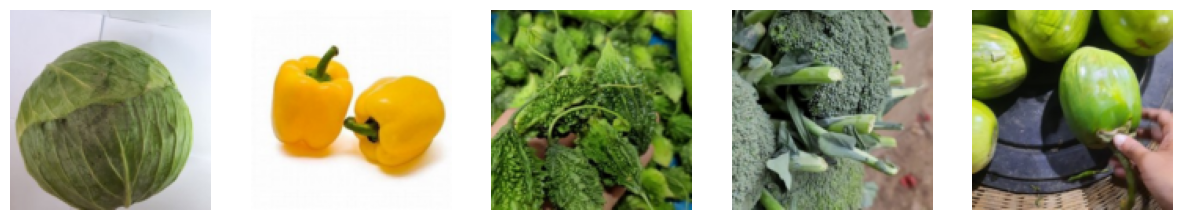

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Случайно переворачиваем изображение по горизонтали
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
show_augmented_images(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
rmsprop_model = VegClassifier(num_classes).to(device)
rmsprop_optimizer = torch.optim.RMSprop(rmsprop_model.parameters(), lr=0.001, alpha=0.99, weight_decay=1e-4)


print("\n=== Training with RMSprop ===")
rmsprop_results = train_and_evaluate(
    rmsprop_model, train_loader, val_loader, test_loader,
    rmsprop_optimizer, criterion, epochs=10, optimizer_name="RMSprop"
)
print(
    f"RMSprop    {rmsprop_results['accuracy']:.4f}     {rmsprop_results['f1']:.4f}     {rmsprop_results['precision']:.4f}     {rmsprop_results['recall']:.4f}")


=== Training with RMSprop ===
Epoch 1/10 | Loss: 0.8765 | Val Acc: 0.8527 | Val F1: 0.8545 | Time: 38.70s
Epoch 2/10 | Loss: 0.3606 | Val Acc: 0.9437 | Val F1: 0.9435 | Time: 35.96s
Epoch 3/10 | Loss: 0.2507 | Val Acc: 0.9250 | Val F1: 0.9248 | Time: 35.45s
Epoch 4/10 | Loss: 0.1954 | Val Acc: 0.9437 | Val F1: 0.9441 | Time: 35.79s
Epoch 5/10 | Loss: 0.1701 | Val Acc: 0.9170 | Val F1: 0.9166 | Time: 35.97s
Epoch 6/10 | Loss: 0.1535 | Val Acc: 0.9283 | Val F1: 0.9286 | Time: 35.77s
Epoch 7/10 | Loss: 0.1361 | Val Acc: 0.9690 | Val F1: 0.9690 | Time: 35.53s
Epoch 8/10 | Loss: 0.1366 | Val Acc: 0.9737 | Val F1: 0.9738 | Time: 35.54s
Epoch 9/10 | Loss: 0.1244 | Val Acc: 0.9760 | Val F1: 0.9760 | Time: 35.38s
Epoch 10/10 | Loss: 0.1106 | Val Acc: 0.9777 | Val F1: 0.9777 | Time: 34.35s
RMSprop    0.9803     0.9803     0.9806     0.9803


 2.3 Обучение с аугментацией яркости, контраста, насыщенности и оттенка (ColorJitter) и оптимизатором RMSprop

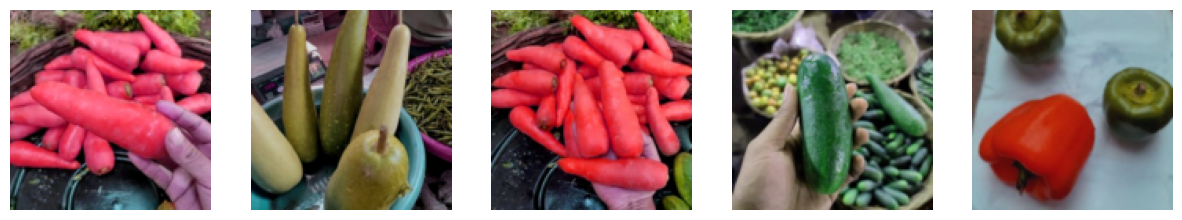

In [ ]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
show_augmented_images(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
rmsprop_model = VegClassifier(num_classes).to(device)
rmsprop_optimizer = torch.optim.RMSprop(rmsprop_model.parameters(), lr=0.001, alpha=0.99, weight_decay=1e-4)


print("\n=== Training with RMSprop ===")
rmsprop_results = train_and_evaluate(
    rmsprop_model, train_loader, val_loader, test_loader,
    rmsprop_optimizer, criterion, epochs=10, optimizer_name="RMSprop"
)
print(
    f"RMSprop    {rmsprop_results['accuracy']:.4f}     {rmsprop_results['f1']:.4f}     {rmsprop_results['precision']:.4f}     {rmsprop_results['recall']:.4f}")


=== Training with RMSprop ===
Epoch 1/10 | Loss: 1.0620 | Val Acc: 0.8737 | Val F1: 0.8735 | Time: 109.41s
Epoch 2/10 | Loss: 0.4919 | Val Acc: 0.7053 | Val F1: 0.7060 | Time: 98.93s
Epoch 3/10 | Loss: 0.3397 | Val Acc: 0.9460 | Val F1: 0.9463 | Time: 99.01s
Epoch 4/10 | Loss: 0.2633 | Val Acc: 0.9687 | Val F1: 0.9688 | Time: 98.12s
Epoch 5/10 | Loss: 0.2231 | Val Acc: 0.9743 | Val F1: 0.9743 | Time: 97.79s
Epoch 6/10 | Loss: 0.2003 | Val Acc: 0.9017 | Val F1: 0.8981 | Time: 98.10s
Epoch 7/10 | Loss: 0.1683 | Val Acc: 0.9767 | Val F1: 0.9766 | Time: 98.90s
Epoch 8/10 | Loss: 0.1630 | Val Acc: 0.8380 | Val F1: 0.8289 | Time: 98.60s
Epoch 9/10 | Loss: 0.1495 | Val Acc: 0.9790 | Val F1: 0.9791 | Time: 98.04s
Epoch 10/10 | Loss: 0.1394 | Val Acc: 0.9647 | Val F1: 0.9650 | Time: 98.15s
RMSprop    0.9843     0.9843     0.9844     0.9843


2.4 Обучение с применением случайного поворота изображений (RandomRotation) и оптимизатором RMSprop

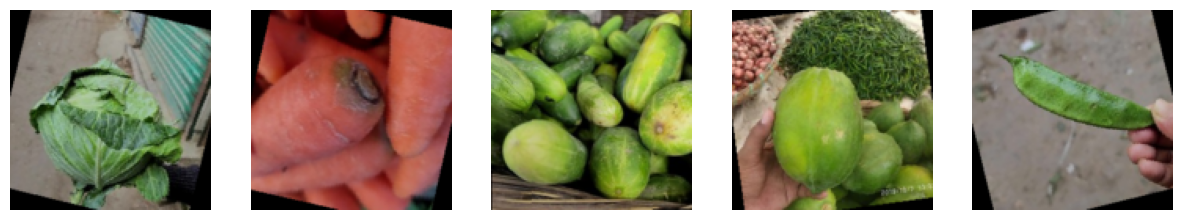

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
show_augmented_images(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
rmsprop_model = VegClassifier(num_classes).to(device)
rmsprop_optimizer = torch.optim.RMSprop(rmsprop_model.parameters(), lr=0.001, alpha=0.99, weight_decay=1e-4)


print("\n=== Training with RMSprop ===")
rmsprop_results = train_and_evaluate(
    rmsprop_model, train_loader, val_loader, test_loader,
    rmsprop_optimizer, criterion, epochs=10, optimizer_name="RMSprop"
)
print(
    f"RMSprop    {rmsprop_results['accuracy']:.4f}     {rmsprop_results['f1']:.4f}     {rmsprop_results['precision']:.4f}     {rmsprop_results['recall']:.4f}")


=== Training with RMSprop ===
Epoch 1/10 | Loss: 0.8196 | Val Acc: 0.8720 | Val F1: 0.8706 | Time: 37.41s
Epoch 2/10 | Loss: 0.3362 | Val Acc: 0.9477 | Val F1: 0.9478 | Time: 37.11s
Epoch 3/10 | Loss: 0.2400 | Val Acc: 0.9420 | Val F1: 0.9421 | Time: 37.60s
Epoch 4/10 | Loss: 0.1882 | Val Acc: 0.9670 | Val F1: 0.9669 | Time: 37.33s
Epoch 5/10 | Loss: 0.1570 | Val Acc: 0.9627 | Val F1: 0.9623 | Time: 37.52s
Epoch 6/10 | Loss: 0.1387 | Val Acc: 0.9727 | Val F1: 0.9728 | Time: 37.98s
Epoch 7/10 | Loss: 0.1368 | Val Acc: 0.9833 | Val F1: 0.9834 | Time: 37.17s
Epoch 8/10 | Loss: 0.1165 | Val Acc: 0.9490 | Val F1: 0.9491 | Time: 37.48s
Epoch 9/10 | Loss: 0.1060 | Val Acc: 0.9837 | Val F1: 0.9836 | Time: 37.30s
Epoch 10/10 | Loss: 0.1046 | Val Acc: 0.9823 | Val F1: 0.9823 | Time: 37.08s
RMSprop    0.9840     0.9840     0.9843     0.9840


2.5 Обучение с комбинированной аугментацией (Flip, Rotation, ColorJitter) и оптимизатором RMSprop

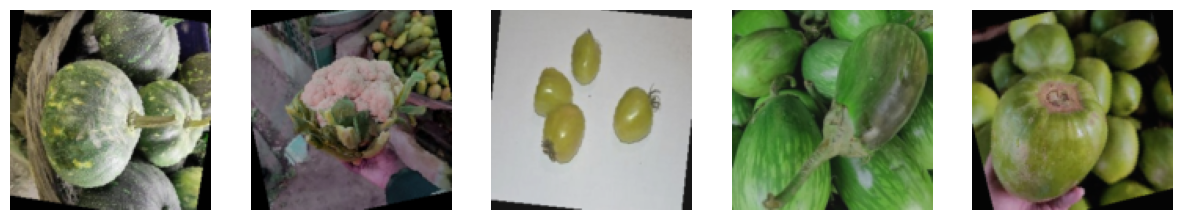

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
show_augmented_images(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
rmsprop_model = VegClassifier(num_classes).to(device)
rmsprop_optimizer = torch.optim.RMSprop(rmsprop_model.parameters(), lr=0.001, alpha=0.99, weight_decay=1e-4)


print("\n=== Training with RMSprop ===")
rmsprop_results = train_and_evaluate(
    rmsprop_model, train_loader, val_loader, test_loader,
    rmsprop_optimizer, criterion, epochs=10, optimizer_name="RMSprop"
)
print(
    f"RMSprop    {rmsprop_results['accuracy']:.4f}     {rmsprop_results['f1']:.4f}     {rmsprop_results['precision']:.4f}     {rmsprop_results['recall']:.4f}")


=== Training with RMSprop ===
Epoch 1/10 | Loss: 1.2564 | Val Acc: 0.8463 | Val F1: 0.8449 | Time: 100.22s
Epoch 2/10 | Loss: 0.6787 | Val Acc: 0.7283 | Val F1: 0.7304 | Time: 99.88s
Epoch 3/10 | Loss: 0.5135 | Val Acc: 0.8627 | Val F1: 0.8631 | Time: 101.22s
Epoch 4/10 | Loss: 0.4136 | Val Acc: 0.8940 | Val F1: 0.8916 | Time: 101.32s
Epoch 5/10 | Loss: 0.3539 | Val Acc: 0.9423 | Val F1: 0.9432 | Time: 99.61s
Epoch 6/10 | Loss: 0.3073 | Val Acc: 0.9597 | Val F1: 0.9596 | Time: 99.80s
Epoch 7/10 | Loss: 0.2990 | Val Acc: 0.9477 | Val F1: 0.9477 | Time: 99.46s
Epoch 8/10 | Loss: 0.2671 | Val Acc: 0.8587 | Val F1: 0.8523 | Time: 100.00s
Epoch 9/10 | Loss: 0.2501 | Val Acc: 0.9583 | Val F1: 0.9584 | Time: 99.61s
Epoch 10/10 | Loss: 0.2233 | Val Acc: 0.9220 | Val F1: 0.9194 | Time: 99.66s
RMSprop    0.9593     0.9592     0.9603     0.9593


2.6 Обучение с горизонтальным отражением (RandomHorizontalFlip) и оптимизатором SGD+momentum

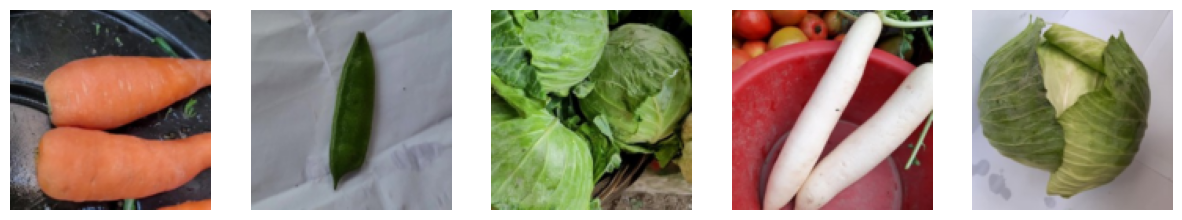

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
show_augmented_images(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

sgd_model = VegClassifier(num_classes).to(device)
sgd_optimizer = torch.optim.SGD(sgd_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
print("\n=== Training with SGD+momentum ===")
sgd_results = train_and_evaluate(
    sgd_model, train_loader, val_loader, test_loader,
    sgd_optimizer, criterion, epochs=10, optimizer_name="SGD"
)
print("\n=== Optimizer Performance Comparison ===")
print(f"{'Optimizer':<10} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 50)
print(
    f"SGD        {sgd_results['accuracy']:.4f}     {sgd_results['f1']:.4f}     {sgd_results['precision']:.4f}     {sgd_results['recall']:.4f}")


=== Training with SGD+momentum ===
Epoch 1/10 | Loss: 1.0061 | Val Acc: 0.8303 | Val F1: 0.8327 | Time: 43.35s
Epoch 2/10 | Loss: 0.4133 | Val Acc: 0.8597 | Val F1: 0.8632 | Time: 36.59s
Epoch 3/10 | Loss: 0.2726 | Val Acc: 0.9563 | Val F1: 0.9564 | Time: 37.89s
Epoch 4/10 | Loss: 0.2121 | Val Acc: 0.9500 | Val F1: 0.9503 | Time: 40.16s
Epoch 5/10 | Loss: 0.1565 | Val Acc: 0.9720 | Val F1: 0.9720 | Time: 41.19s
Epoch 6/10 | Loss: 0.1227 | Val Acc: 0.9587 | Val F1: 0.9585 | Time: 35.01s
Epoch 7/10 | Loss: 0.0975 | Val Acc: 0.9633 | Val F1: 0.9632 | Time: 34.77s
Epoch 8/10 | Loss: 0.0866 | Val Acc: 0.9820 | Val F1: 0.9821 | Time: 34.76s
Epoch 9/10 | Loss: 0.0810 | Val Acc: 0.9693 | Val F1: 0.9694 | Time: 35.02s
Epoch 10/10 | Loss: 0.0658 | Val Acc: 0.9830 | Val F1: 0.9829 | Time: 34.15s

=== Optimizer Performance Comparison ===
Optimizer  Accuracy   F1 Score   Precision  Recall    
--------------------------------------------------
SGD        0.9860     0.9860     0.9862     0.9860


2.7 Обучение с аугментацией цвета (ColorJitter) и оптимизатором SGD+momentum

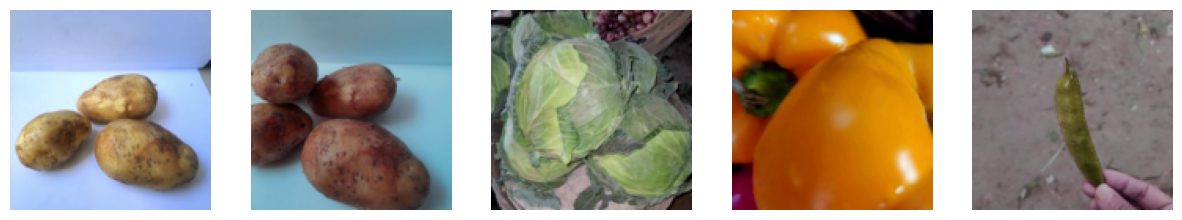

In [ ]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
show_augmented_images(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

sgd_model = VegClassifier(num_classes).to(device)
sgd_optimizer = torch.optim.SGD(sgd_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
print("\n=== Training with SGD+momentum ===")
sgd_results = train_and_evaluate(
    sgd_model, train_loader, val_loader, test_loader,
    sgd_optimizer, criterion, epochs=10, optimizer_name="SGD"
)
print("\n=== Optimizer Performance Comparison ===")
print(f"{'Optimizer':<10} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 50)
print(
    f"SGD        {sgd_results['accuracy']:.4f}     {sgd_results['f1']:.4f}     {sgd_results['precision']:.4f}     {sgd_results['recall']:.4f}")


=== Training with SGD+momentum ===
Epoch 1/10 | Loss: 1.2210 | Val Acc: 0.8563 | Val F1: 0.8573 | Time: 100.78s
Epoch 2/10 | Loss: 0.6004 | Val Acc: 0.9113 | Val F1: 0.9121 | Time: 97.99s
Epoch 3/10 | Loss: 0.3767 | Val Acc: 0.8953 | Val F1: 0.8979 | Time: 97.26s
Epoch 4/10 | Loss: 0.2956 | Val Acc: 0.9510 | Val F1: 0.9510 | Time: 98.12s
Epoch 5/10 | Loss: 0.2137 | Val Acc: 0.9403 | Val F1: 0.9401 | Time: 97.83s
Epoch 6/10 | Loss: 0.1744 | Val Acc: 0.9723 | Val F1: 0.9724 | Time: 97.87s
Epoch 7/10 | Loss: 0.1373 | Val Acc: 0.9753 | Val F1: 0.9753 | Time: 97.57s
Epoch 8/10 | Loss: 0.1197 | Val Acc: 0.9790 | Val F1: 0.9790 | Time: 98.48s
Epoch 9/10 | Loss: 0.1142 | Val Acc: 0.9807 | Val F1: 0.9807 | Time: 97.98s
Epoch 10/10 | Loss: 0.0925 | Val Acc: 0.9840 | Val F1: 0.9840 | Time: 98.13s

=== Optimizer Performance Comparison ===
Optimizer  Accuracy   F1 Score   Precision  Recall    
--------------------------------------------------
SGD        0.9847     0.9847     0.9849     0.9847


2.8 Обучение с случайным поворотом изображений (RandomRotation) и оптимизатором SGD+momentum

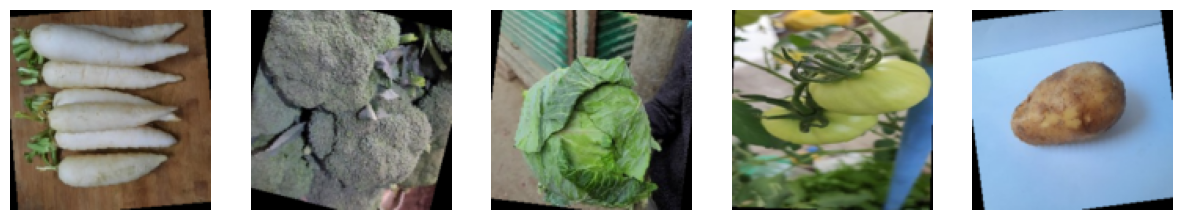

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
show_augmented_images(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

sgd_model = VegClassifier(num_classes).to(device)
sgd_optimizer = torch.optim.SGD(sgd_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
print("\n=== Training with SGD+momentum ===")
sgd_results = train_and_evaluate(
    sgd_model, train_loader, val_loader, test_loader,
    sgd_optimizer, criterion, epochs=10, optimizer_name="SGD"
)
print("\n=== Optimizer Performance Comparison ===")
print(f"{'Optimizer':<10} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 50)
print(
    f"SGD        {sgd_results['accuracy']:.4f}     {sgd_results['f1']:.4f}     {sgd_results['precision']:.4f}     {sgd_results['recall']:.4f}")


=== Training with SGD+momentum ===
Epoch 1/10 | Loss: 0.9110 | Val Acc: 0.8453 | Val F1: 0.8459 | Time: 40.23s
Epoch 2/10 | Loss: 0.3817 | Val Acc: 0.9233 | Val F1: 0.9235 | Time: 42.67s
Epoch 3/10 | Loss: 0.2340 | Val Acc: 0.9533 | Val F1: 0.9534 | Time: 38.73s
Epoch 4/10 | Loss: 0.1546 | Val Acc: 0.9597 | Val F1: 0.9598 | Time: 38.06s
Epoch 5/10 | Loss: 0.1361 | Val Acc: 0.9763 | Val F1: 0.9763 | Time: 38.59s
Epoch 6/10 | Loss: 0.1019 | Val Acc: 0.9577 | Val F1: 0.9577 | Time: 38.10s
Epoch 7/10 | Loss: 0.0856 | Val Acc: 0.9847 | Val F1: 0.9847 | Time: 38.33s
Epoch 8/10 | Loss: 0.0706 | Val Acc: 0.9837 | Val F1: 0.9837 | Time: 38.32s
Epoch 9/10 | Loss: 0.0638 | Val Acc: 0.9833 | Val F1: 0.9834 | Time: 38.50s
Epoch 10/10 | Loss: 0.0571 | Val Acc: 0.9847 | Val F1: 0.9847 | Time: 37.52s

=== Optimizer Performance Comparison ===
Optimizer  Accuracy   F1 Score   Precision  Recall    
--------------------------------------------------
SGD        0.9800     0.9800     0.9805     0.9800


2.9 Обучение с комбинированной аугментацией (Flip, Rotation, ColorJitter) и оптимизатором SGD+momentum

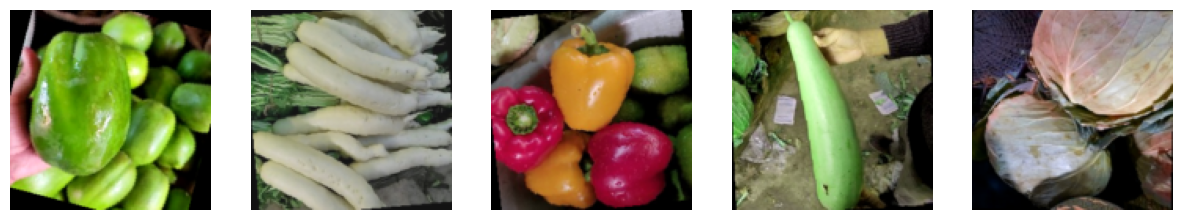

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
show_augmented_images(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

sgd_model = VegClassifier(num_classes).to(device)
sgd_optimizer = torch.optim.SGD(sgd_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
print("\n=== Training with SGD+momentum ===")
sgd_results = train_and_evaluate(
    sgd_model, train_loader, val_loader, test_loader,
    sgd_optimizer, criterion, epochs=10, optimizer_name="SGD"
)
print("\n=== Optimizer Performance Comparison ===")
print(f"{'Optimizer':<10} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 50)
print(
    f"SGD        {sgd_results['accuracy']:.4f}     {sgd_results['f1']:.4f}     {sgd_results['precision']:.4f}     {sgd_results['recall']:.4f}")


=== Training with SGD+momentum ===
Epoch 1/10 | Loss: 1.4421 | Val Acc: 0.7873 | Val F1: 0.7879 | Time: 120.81s
Epoch 2/10 | Loss: 0.8306 | Val Acc: 0.8643 | Val F1: 0.8668 | Time: 111.61s
Epoch 3/10 | Loss: 0.5941 | Val Acc: 0.8980 | Val F1: 0.8990 | Time: 101.06s
Epoch 4/10 | Loss: 0.4774 | Val Acc: 0.9083 | Val F1: 0.9094 | Time: 100.32s
Epoch 5/10 | Loss: 0.3970 | Val Acc: 0.9570 | Val F1: 0.9571 | Time: 100.44s
Epoch 6/10 | Loss: 0.3273 | Val Acc: 0.9610 | Val F1: 0.9611 | Time: 99.83s
Epoch 7/10 | Loss: 0.2907 | Val Acc: 0.9577 | Val F1: 0.9578 | Time: 100.23s
Epoch 8/10 | Loss: 0.2533 | Val Acc: 0.9667 | Val F1: 0.9667 | Time: 101.31s
Epoch 9/10 | Loss: 0.2296 | Val Acc: 0.9593 | Val F1: 0.9596 | Time: 100.49s
Epoch 10/10 | Loss: 0.2145 | Val Acc: 0.9760 | Val F1: 0.9760 | Time: 100.09s

=== Optimizer Performance Comparison ===
Optimizer  Accuracy   F1 Score   Precision  Recall    
--------------------------------------------------
SGD        0.9687     0.9686     0.9696     0.

2.10 Сравнительная таблица точности моделей с разными аугментациями и оптимизаторами

In [ ]:
import pandas as pd

# Данные
index = ['Без аугментаций', 'RandomHorizontalFlip', 'ColorJitter', 'RandomRotation', 'Все аугментации']
columns = ['RMSprop', 'SGD']
data = {
    'RMSprop': [0.9737, 0.9803, 0.9843, 0.9840, 0.9593],
    'SGD': [0.9863, 0.9860, 0.9847, 0.9800, 0.9687]
}

# Создаем DataFrame
results_df = pd.DataFrame(data, index=index, columns=columns)

# Форматируем значения в проценты с 2 знаками после запятой
results_df = results_df.style.format({
    'RMSprop': '{:.2%}'.format,
    'SGD': '{:.2%}'.format
})

# Отображаем таблицу
results_df

## Вывод по результатам обучения CNN-модели VegClassifier с различными аугментациями и оптимизаторами

- **Без аугментаций** SGD показал наилучшую точность — **98.63%**, что немного выше, чем у RMSprop (**97.37%**).
- При использовании **горизонтального отражения (RandomHorizontalFlip)** обе модели показали прирост точности: **98.60%** (SGD) и **98.03%** (RMSprop).
- Наилучший результат у RMSprop был достигнут при применении **ColorJitter** (**98.43%**), что свидетельствует о высокой чувствительности модели к вариациям цвета.
- **Случайный поворот (RandomRotation)** дал стабильный прирост обеим моделям, при этом разница между ними составила всего **0.40%** в пользу RMSprop.
- Интересно, что при комбинировании всех аугментаций наблюдается **снижение точности** у обеих моделей (**96.87%** у SGD и **95.93%** у RMSprop), что может указывать на избыточное усложнение входных данных и ухудшение обобщающей способности модели.

Таким образом, **наиболее эффективной аугментацией** оказалась **ColorJitter**, особенно в сочетании с RMSprop, а **наилучшие итоговые результаты** продемонстрировал оптимизатор **SGD с momentum**, особенно в отсутствии или при минимальной аугментации. Комбинирование всех аугментаций не дало улучшения и даже снизило точность, что подчёркивает важность тщательного подбора методов расширения обучающей выборки.

## 3. Построение и анализ латентного пространства изображений с помощью модели VegClassifier (Исследование Константина Сидорова)

3.1 Загрузка и сохранение модели с наилучшей точностью среди всех оптимизаторов

In [ ]:
# Находим оптимизатор с максимальной точностью на тесте
best_name, _ = max(
    [("SGD", sgd_results), ("Adam", adam_results), ("RMSprop", rmsprop_results)],
    key=lambda x: x[1]['accuracy']
)

# Загружаем и сохраняем под общим именем
best_model = VegClassifier(num_classes).to(device)
best_model.load_state_dict(torch.load(f"vegetable_cnn_{best_name}.pt"))
best_model.eval()

3.2 Привязка метода извлечения эмбеддингов к лучшей модели (extract_embedding)

In [ ]:
# Привязываем метод извлечения эмбеддингов
from types import MethodType
def extract_embedding(self, x):
    with torch.no_grad():
        x = self.conv_layers(x)
        x = self.classifier[:4](x)
    return x

best_model.extract_embedding = MethodType(extract_embedding, best_model)

Почему используется `self.classifier[:4]` для извлечения эмбеддингов

В модели `VegClassifier` классификационная часть (`self.classifier`) реализована через `nn.Sequential` и состоит из следующих слоёв:

```python
nn.Sequential(
    nn.Flatten(),                # [0]
    nn.Linear(256 * 8 * 8, 512), # [1]
    nn.BatchNorm1d(512),         # [2]
    nn.ReLU(),                   # [3]
    nn.Dropout(0.5),             # [4]
    nn.Linear(512, num_classes)  # [5]
)
```

При построении эмбеддинга изображения важно извлекать не выход модели (где уже сделан выбор класса), а именно промежуточное латентное представление, в котором кодируются информативные признаки изображения.

Поэтому мы берём только первые четыре слоя с помощью `self.classifier[:4]`. Это включает:
- выравнивание изображения в вектор (Flatten),
- полносвязный слой до размерности 512,
- нормализацию признаков (BatchNorm),
- и функцию активации ReLU.

Именно результат после этих слоёв — это эмбеддинг изображения, то есть плотное векторное представление в латентном пространстве. Такой вектор можно использовать, например, для поиска ближайших изображений по расстоянию между эмбеддингами.

3.3 Извлечение эмбеддингов и изображений из тестовой выборки с использованием лучшей модели

In [ ]:
all_embeddings = []
all_images = []
all_labels = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        embeddings = best_model.extract_embedding(images)  # (batch_size, 128)
        all_embeddings.append(embeddings.cpu())
        all_images.extend(images.cpu())  # сохраняем сами картинки
        all_labels.extend(labels)

# Объединяем всё в один тензор
all_embeddings = torch.cat(all_embeddings, dim=0)

3.4 Поиск ближайших изображений в латентном пространстве (евклидова метрика)

In [ ]:
# Случайный индекс
query_idx = random.randint(0, len(all_embeddings) - 1)
query_embedding = all_embeddings[query_idx].unsqueeze(0)

# Вычисляем расстояния (L2)
distances = euclidean_distances(query_embedding, all_embeddings.numpy())[0]
nearest_indices = np.argsort(distances)[1:6]  # исключаем саму картинку

3.5 Визуализация запроса и пяти ближайших изображений в латентном пространстве

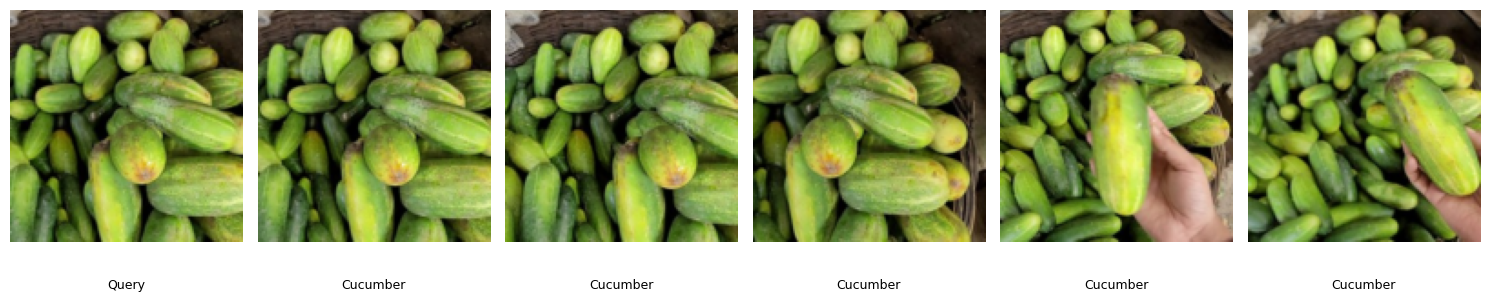

In [ ]:
def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return tensor * std + mean

fig, axs = plt.subplots(1, 6, figsize=(15, 4))

# Показываем запрос
img = denormalize(all_images[query_idx])
axs[0].imshow(img.permute(1, 2, 0).numpy())
axs[0].text(0.5, -0.2, "Query", fontsize=9, ha='center', transform=axs[0].transAxes)
axs[0].axis('off')

# Показываем 5 ближайших
for i, idx in enumerate(nearest_indices):
    img = denormalize(all_images[idx])
    axs[i + 1].imshow(img.permute(1, 2, 0).numpy())
    label = train_dataset.classes[all_labels[idx]]
    axs[i + 1].text(0.5, -0.2, label, fontsize=9, ha='center', transform=axs[i + 1].transAxes)
    axs[i + 1].axis('off')

plt.tight_layout()
plt.show()

## Вывод по работе с моделью VegClassifier и анализом латентного пространства

В ходе исследования была разработана и обучена сверточная нейронная сеть `VegClassifier` для классификации изображений овощей. После оценки качества модели с различными оптимизаторами (SGD, Adam, RMSprop) была выбрана лучшая модель по точности на тестовой выборке. Далее работа была сосредоточена на анализе внутренних представлений, формируемых моделью.

Для этого был реализован специальный метод `extract_embedding`, позволяющий извлекать эмбеддинги изображений из промежуточного слоя модели (до финального линейного классификатора). Эти векторы представляют собой компактные латентные описания изображений, сформированные в процессе обучения.

На основе эмбеддингов:
- Было реализовано вычисление евклидовых расстояний между изображениями в латентном пространстве,
- Выполнен поиск ближайших изображений к случайно выбранному запросу,
- Проведена визуализация оригинального изображения и пяти наиболее близких к нему по признаковому пространству.

Результаты показали, что обученная модель эффективно группирует изображения на основе визуального сходства, даже без явного использования классов. Это подтверждает, что `VegClassifier` формирует осмысленные внутренние представления, которые можно использовать не только для классификации, но и для задач поиска, кластеризации и визуального анализа.

## Бонусная часть (Вместо бинарной классификации)

### Использование предобученной модели VGG16 (Transfer Learning)

В данной части проекта мы применяем метод **transfer learning** — перенос знаний с одной задачи на другую. Это позволяет использовать готовую нейронную сеть, обученную на большом датасете (ImageNet), и адаптировать её под нашу задачу классификации изображений овощей.

### Что такое VGG16?

VGG16 — это одна из классических сверточных нейронных сетей, предложенная Visual Geometry Group (Оксфорд, 2014). Она обучена на датасете ImageNet и состоит из 13 сверточных слоев и 3 полносвязных. Архитектура VGG основана на идее использования простых свёрток 3×3 и пулингов 2×2, но в глубокой и однородной структуре.

### Что мы делаем?

1. Загружаем предобученную модель `VGG16` из библиотеки `torchvision.models` с весами, обученными на ImageNet.
2. Замораживаем все сверточные слои (`features`), чтобы не обновлять их веса. Это позволяет использовать ранее извлечённые универсальные признаки, такие как формы, текстуры, края и т.д.
3. Заменяем последний классификатор (`classifier`) на новый, соответствующий числу классов в нашем датасете.
4. Обучаем только новую "голову" модели (классификатор), используя кросс-энтропийную функцию потерь.
5. Сохраняем лучшую модель по метрике accuracy на валидационной выборке.
6. После обучения проводим тестирование на независимой выборке, чтобы оценить финальную точность модели.

### Почему это эффективно?

Предобученные модели, особенно на больших датасетах, уже "знают" как извлекать общие визуальные признаки. Это позволяет обучать новые модели быстрее и с меньшим риском переобучения, особенно при ограниченном количестве собственных данных. Кроме того, такой подход часто показывает более высокое качество по сравнению с обучением сети "с нуля".

In [ ]:
# Загружаем предобученную VGG16
TransferVGG = models.vgg16(pretrained=True)

# Замораживаем сверточные слои (features)
for param in TransferVGG.features.parameters():
    param.requires_grad = False

# Заменяем классификатор под число классов
TransferVGG.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

# Переносим на GPU/CPU
TransferVGG = TransferVGG.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.0MB/s]


In [ ]:
# Оптимизируем только параметры классификатора
optimizer = torch.optim.Adam(TransferVGG.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
best_val_acc = 0

for epoch in range(num_epochs):
    TransferVGG.train()
    total, correct, train_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = TransferVGG(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # Валидация
    TransferVGG.eval()
    val_total, val_correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = TransferVGG(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(TransferVGG.state_dict(), "best_transfer_vgg.pt")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/10] | Train Acc: 0.9561 | Val Acc: 0.9877
Epoch [2/10] | Train Acc: 0.9881 | Val Acc: 0.9893
Epoch [3/10] | Train Acc: 0.9889 | Val Acc: 0.9847
Epoch [4/10] | Train Acc: 0.9908 | Val Acc: 0.9947
Epoch [5/10] | Train Acc: 0.9937 | Val Acc: 0.9937
Epoch [6/10] | Train Acc: 0.9904 | Val Acc: 0.9913
Epoch [7/10] | Train Acc: 0.9947 | Val Acc: 0.9937
Epoch [8/10] | Train Acc: 0.9959 | Val Acc: 0.9920
Epoch [9/10] | Train Acc: 0.9940 | Val Acc: 0.9943
Epoch [10/10] | Train Acc: 0.9973 | Val Acc: 0.9963


In [ ]:
# Загружаем лучшую сохранённую модель
TransferVGG.load_state_dict(torch.load("best_transfer_vgg.pt"))
TransferVGG.eval()

test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = TransferVGG(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"\n Test Accuracy (TransferVGG): {100 * test_correct / test_total:.2f}%")


 Test Accuracy (TransferVGG): 99.50%


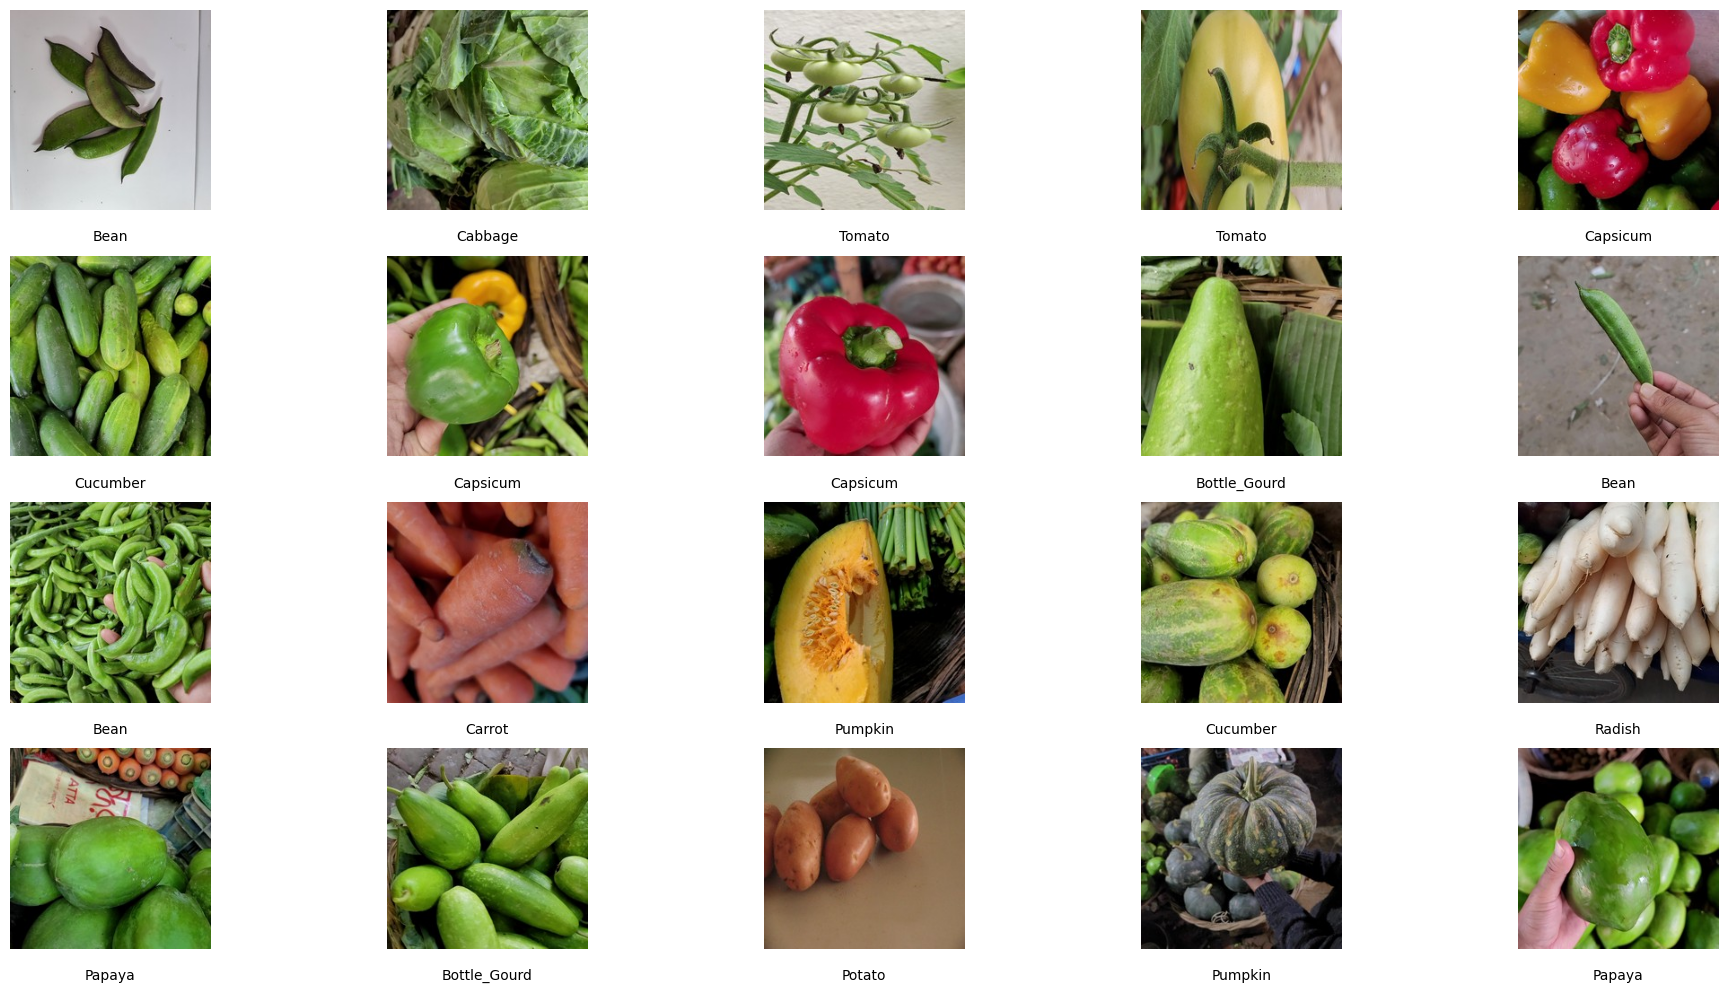

In [ ]:
# Вспомогательная функция: показать изображение
def imshow(img, ax):
    img = img.numpy().transpose((1, 2, 0))  # CxHxW → HxWxC
    ax.imshow(img)
    ax.axis('off')

# Класс-обратный словарь
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# Настраиваем визуализацию
TransferVGG.eval()
fig = plt.figure(figsize=(20, 10))

with torch.no_grad():
    for i in range(20):
        # случайный индекс
        idx = random.randint(0, len(test_dataset) - 1)
        image, label = test_dataset[idx]
        input_img = image.unsqueeze(0).to(device)

        # предсказание
        output = TransferVGG(input_img)
        _, predicted = torch.max(output, 1)
        predicted_label = idx_to_class[predicted.item()]

        # отображение изображения
        ax = fig.add_subplot(4, 5, i + 1)
        imshow(image, ax)
        ax.text(0.5, -0.1, predicted_label, transform=ax.transAxes,
                fontsize=10, ha='center', va='top')
        ax.axis('off')

plt.tight_layout()
plt.show()